# Forward Autodifferentiation

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Dual Numbers

First, we define a new data type, called dual numbers, and define its arithmatic in accordance with the rules of calculus.

In [2]:
class dual(object):
    def __init__(self,real,dual=0):
        self.real = real
        self.dual = dual
        
    def __str__(self):
        return "%f + %f dx" %(self.real,self.dual)
    
    def __mul__(self,other):
        if not isinstance(other,dual):
            other = dual(other)
        return dual(self.real*other.real, (self.real*other.dual) + (other.real*self.dual))
    
    __rmul__ = __mul__
    
    def __add__(self,other):
        if not isinstance(other,dual):
            other = dual(other)
        return dual(self.real+other.real,self.dual+other.dual)
    
    __radd__ = __add__
    
    def __neg__(self):
        return dual(-self.real,-self.dual)
    
    def __sub__(self,other):
        if not isinstance(other,dual):
            other = dual(other)
        return self +  (-other)
    
    def __rsub__(self,other):
        if not isinstance(other,dual):
            other = dual(other)
        return other + (-self)
    
    def __truediv__(self,other):
        if not isinstance(other,dual):
            other = dual(other)
        return dual(self.real/other.real,(self.dual*other.real - self.real*other.dual)/(other.real*other.real))
    
    def __rtruediv__(self,other):
        if not isinstance(other,dual):
            other = dual(other)
        return dual(other.real/self.real,(other.dual*self.real - other.real*self.dual)/(self.real*self.real))
    
    def __len__(self):
        return len(self.real)

We just check the arithmetic - by default, we set the "dual" part to 0.

In [3]:
x = 3
y = dual(x)
print(y)

3.000000 + 0.000000 dx


In [4]:
z = 1/y
print(z)

0.333333 + 0.000000 dx


In [5]:
w = dual(1.0,2.0)
a = y/w
b = x*w
c = x-w
print(a)
print(b)
print(c)

3.000000 + -6.000000 dx
3.000000 + 6.000000 dx
2.000000 + -2.000000 dx


### Necessary Functions

This is what we were hoping to see. Next, we overload the sqrt function and the transcendental functions exp, cos, and sin. Most other functions we need can be written in terms of these functions.

In [6]:
def exp(x):
    if not isinstance(x,dual):
        x = dual(x,0)
    return dual(np.exp(x.real),np.exp(x.real)*x.dual)
    
def cos(x):
    if not isinstance(x,dual):
        x = dual(x,0)
    return dual(np.cos(x.real),-np.sin(x.real)*x.dual)
    
def sin(x):
    if not isinstance(x,dual):
        x = dual(x,0)
    return dual(np.sin(x.real),np.cos(x.real)*x.dual)

def sqrt(x):
    if not isinstance(x,dual):
        x = dual(x,0)
    return dual(np.sqrt(x.real),x.dual/(2.0*np.sqrt(x.real)))

### Here, we define the function D, which acts as a differential operator.

In [7]:
def D(f,x):
    if not isinstance(x,dual):
        x = dual(x,1)
    return f(x).dual

In [8]:
print(cos(x))

-0.989992 + -0.000000 dx


### Some trials

In [9]:
xs = np.linspace(0,10*pi,1001)
ys = [cos(x).real for x in xs]
yprimes = [D(cos,x) for x in xs]

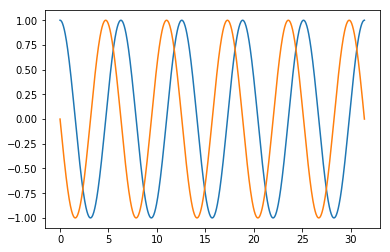

In [10]:
plot(xs,ys)
plot(xs,yprimes)

This is what we were hoping to see as $\frac{dcosx}{dx} = -sinx$.

In order to check if basic chain rule works, we want to see if our operator D gives us the same result for $\frac{dcos(-x)}{dx} = -sinx$.

In [11]:
def cosneg(x):
    return cos(-x)
x1s = xs
y1s = [cos(-x).real for x in x1s]
y1primes = [D(cosneg,x) for x in x1s]

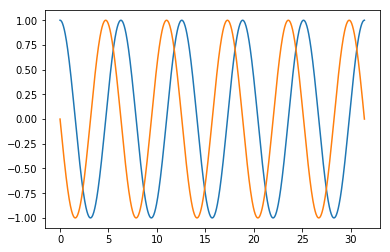

In [12]:
plot(x1s,y1s)
plot(x1s,y1primes)

This checks out. Phew. Never doubted it for even a second. 

What would also be interesting to see, is if we can take the derivative of something other than just $x$. Let us check what happens when we take $\frac{dcos(-x)}{d(-x)} = -sin(-x) = sin(x)$. 

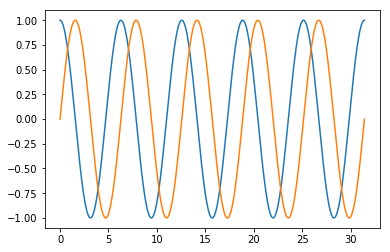

In [13]:
x2s = xs
y2s = [cos(-x).real for x in x2s]
y2primes = [D(cosneg,-x) for x in x2s]
plot(x2s,y2s)
plot(x2s,y2primes)

This works as well (at least at eye level). Let us quantify the errors between what we get from our differential operator and an analytical solution for a slightly more complicated function. The following example also will ensure that our implemetation performs the product and chain rules. 

In [14]:
freq = np.sqrt(2)
def f(x):
    return exp(-x/pi)*sin(2.0*pi*freq*x)

def fprime(x):
    return exp(-x/pi)*(2*pi*freq*cos(2*pi*freq*x) - sin(2*pi*freq*x)/pi)

In [15]:
x2s = np.linspace(0,2*pi,1001)
y2s = [f(x).real for x in x2s]
y2primes = [D(f,x) for x in x2s]

Text(0.5, 1.0, 'f and Df using AutoDiff')

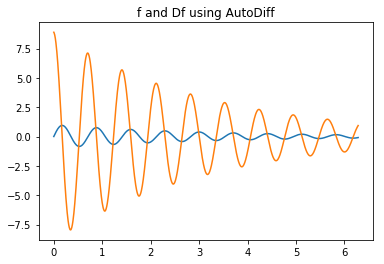

In [16]:
plot(x2s,y2s)
plot(x2s,y2primes)
title('f and Df using AutoDiff')

Text(0.5, 1.0, 'f and Df using Analytical Expression')

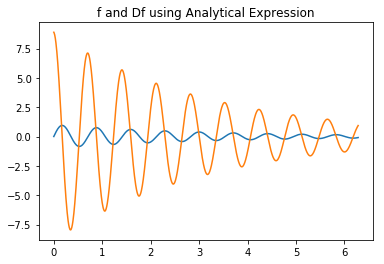

In [17]:
y2analys = [fprime(x).real for x in x2s]
plot(x2s,y2s)
plot(x2s,y2analys)
title('f and Df using Analytical Expression')

Text(0, 0.5, 'Errors between AutoDiff and Analytical Expression')

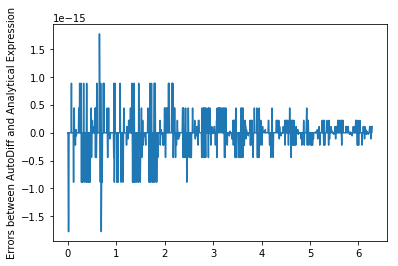

In [18]:
errs = [(D(f,x)-fprime(x).real) for x in x2s]
plot(x2s,errs)
ylabel('Errors between AutoDiff and Analytical Expression')

## THIS IS OF THE ORDER OF MACHINE PRECISION!

Now, we proceed to implement a few other functions from the ones we have above.

In [19]:
def tan(x):
    return sin(x)/cos(x)

def cot(x):
    return cos(x)/sin(x)

def sec(x):
    return 1/cos(x)

def csc(x):
    return 1/sin(x)

def sinh(x):
    return 0.5*(exp(x)-exp(-x))

def cosh(x):
    return 0.5*(exp(x)+exp(-x))

def tanh(x):
    return sinh(x)/cosh(x)

def coth(x):
    return cosh(x)/sinh(x)

def ln(x):
    if not isinstance(x,dual):
        x = dual(x,0)
    return dual(np.ln(x.real),x.dual/x.real)

def log(x,base):
    return ln(x)/ln(base)

In the future, I would like to complete this implementaion by extending to this class of dual numbers as much of a standard library of mathematical functions as possible. In particular, inverse functions and their derivatives have to be implemented. 

We know the following relation from calculus.

$$f^{-1}(x)' = \frac{1}{f'(f^{-1}(x))}$$

Perhaps this would help in implementing inverse functions without having to resort to analytical calculations.